In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install cartopy==0.19.0.post1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
# sys.path.append("../../")
sys.path.append('/content/drive/MyDrive/CSE 499A/timedelay')
import numpy as np
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pandas as pd
import seaborn as sns
import xarray as xr
import keras


import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# from python.aux.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study
# from python.aux.plot import plot_multif_prediction

In [ ]:
def get_mask_of_basin(da, kw_basins='Danube'):
    """Return a mask where all points outside the selected basin are False.
    Parameters:
    -----------
    da : xr.DataArray
        contains the coordinates
    kw_basins : str
        identifier of the basin in the basins dataset
    """
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/' \
           + 'drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    da = da.basins == 0
    return da.drop('basins')  # the basins coordinate is not used anymore from here on


def select_upstream(mask_river_in_catchment, lat, lon, basin='Danube'):
    """Return a mask containing upstream river gridpoints.
    Parameters
    ----------
    mask_river_in_catchment : xr.DataArray
        array that is True only for river gridpoints within a certain catchment
        coords: only latitude and longitute
    lat, lon : float
        latitude and longitude of the considered point
    basin : str
        identifier of the basin in the basins dataset
    Returns
    -------
    xr.DataArray
        0/1 mask array with (latitude, longitude) as coordinates
    """

    # this condition should be replaced with a terrain dependent mask
    # but generally speaking, there will always be some points returned that
    # do not influence the downstream point;
    # the statistical model should ignore those points as learned from the dataset
    da = mask_river_in_catchment.load()
    is_west = (~np.isnan(da.where(da.longitude <= lon))).astype(bool)

    mask_basin = get_mask_of_basin(da, kw_basins=basin)

    nearby_mask = da*0.
    nearby_mask.loc[dict(latitude=slice(lat+1.5, lat-1.5),
                         longitude=slice(lon-1.5, lon+1.5))] = 1.
    nearby_mask = nearby_mask.astype(bool)

    mask = mask_basin & nearby_mask & is_west & mask_river_in_catchment

    if 'basins' in mask.coords:
        mask = mask.drop('basins')
    if 'time' in mask.coords:
        mask = mask.drop('time')  # time and basins dimension make no sense here
    return mask


def add_shifted_variables(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list(int, )
        e.g. range(1,4); shift=1 means having the value x(t=0) at t=1
    variables : str or list
        e.g. ['lsp', 'cp']
    Returns
    -------
    xr.Dataset
        the input Dataset with the shifted timeseries added as additional variable
    """
    if isinstance(ds, xr.DataArray):
        ds = ds.to_dataset()  # enforce input type

    if variables == 'all':
        variables = ds.data_vars

    for var in variables:
        for i in shifts:
            if i == 0:
                continue  # zero-shift is the original timeseries
            if i > 0:
                sign = '-'
            else:
                sign = '+'
            newvar = var+sign+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds


def shift_and_aggregate(df, shift, aggregate):
    """
    To get a predictor from [lsp(t-3), ..., lsp(t-6)],
    use shift = 3 and aggregate = 3
    Parameters
    ----------
    shift : int
    aggregate : int
    """
    return df.shift(time=shift).rolling(time=aggregate).sum()/aggregate


def aggregate_clustersum(ds, cluster, clusterdim):
    """Aggregate a 3-dimensional array over certain points (latitude, longitude).
    Parameters
    ----------
    ds : xr.Dataset
        the array to aggregate (collapse) spatially
    cluster : xr.DataArray
        3-dimensional array (clusterdim, latitude, longitude),
        `clusterdim` contains the True/False mask of points to aggregate over
        e.g. len(clusterdim)=4 means you have 4 clusters
    clusterdim : str
        dimension name to access the different True/False masks
    Returns
    -------
    xr.DataArray
        1-dimensional
    """
    out = xr.Dataset()

    # enforce same coordinates
    interp = True
    if (len(ds.latitude.values) == len(cluster.latitude.values) and
            len(ds.longitude.values) == len(cluster.longitude.values)):
        if (np.allclose(ds.latitude.values, cluster.latitude.values) and
                np.allclose(ds.longitude.values, cluster.longitude.values)):
            interp = False
    if interp:
        ds = ds.interp(latitude=cluster.latitude, longitude=cluster.longitude)
    area_per_gridpoint = calc_area(ds.isel(time=0))

    if isinstance(ds, xr.DataArray):
        ds = ds.to_dataset()

    for var in ds:
        for cl in cluster.coords[clusterdim]:
            newname = var+'_cluster'+str(cl.values)
            this_cluster = cluster.sel({clusterdim: cl})

            da = ds[var].where(this_cluster, 0.)  # no contribution from outside cluster
            out[newname] = xr.dot(da, area_per_gridpoint)
    return out.drop(clusterdim)


def cluster_by_discharge(dis_2d, bin_edges):
    """Custom clustering by discharge.
    """
    cluster = dict()
    for i in range(len(bin_edges)-1):
        cluster[str(i)] = (dis_2d >= bin_edges[i]) & (dis_2d < bin_edges[i+1])
        cluster[str(i)].attrs['units'] = None

    return xr.Dataset(cluster,
                      coords=dict(clusterId=('clusterId', range(len(bin_edges))),
                                  latitude=('latitude', dis_2d.latitude),
                                  longitude=('longitude', dis_2d.longitude)))


def reshape_scalar_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.
    Parameters
    ----------
    X_dis : xr.Dataset
        variables: time shifted predictors (name irrelevant)
        coords: time, latitude, longitude
    y : xr.DataArray
        coords: time
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    if isinstance(y, xr.Dataset):
        if len(y.data_vars) > 1:
            warnings.warn('Supplied `y` with more than one variable.'
                          'Which is the predictand? Supply only one!')
        for v in y:
            y = y[v]  # use the first
            break

    yar = y
    if len(yar.dims) > 1:
        raise NotImplementedError('y.dims: '+str(yar.dims) +
                                  ' Supply only one predictand dimension, e.g. `time`!')

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in yar.coords:
            yar = yar.drop(coord)

    # merge times
    yar.coords['features'] = 'predictand'
    Xy = xr.concat([Xar, yar], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-1]  # last column is predictand
    yda = Xyt[:, -1].drop('features')  # features was only needed in merge
    return Xda, yda


def multiday_prediction_to_timeseries(prediction):
    """Convert a 2-dimensional xarray to 1-dimensional with nonunique time-index.
    Parameters
    ----------
    xar : xr.DataArray
        2-dimensional xarray (init_time, forecast_day)
    Returns
    -------
    xr.DataArray
        1-dimensional (time) array with nonunique time index
    """
    forecast_days = len(prediction.forecast_day)
    inits = np.array(prediction.init_time)[:, np.newaxis]

    # repeat the initial time for every forecast day in a column
    times = np.repeat(inits, forecast_days, axis=1)

    # add the forecast day to each column
    for i, day in enumerate(prediction.forecast_day.values):
        times[:, i] += np.timedelta64(day, 'D')

    times = times.ravel()
    data = prediction.values.ravel()
    return pd.Series(data, index=times)


def reshape_multiday_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.
    Parameters
    ----------
    X_dis : xr.Dataset
        variables: time shifted predictors (name irrelevant)
        coords: time, latitude, longitude
    y : xr.DataArray (multiple variables, multiple timesteps)
        coords: time, forecast_day
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    if not isinstance(y, xr.DataArray):
        raise TypeError('Supply `y` as xr.DataArray.'
                        'with coords (time, forecast_day)!')

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in y.coords:
            y = y.drop(coord)

    out_dim = len(y.forecast_day)
    y = y.rename(dict(forecast_day='features'))  # rename temporarily
    Xy = xr.concat([Xar, y], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-out_dim]  # last column is predictand
    yda = Xyt[:, -out_dim:]  # features was only needed in merge
    yda = yda.rename(dict(features='forecast_day'))  # change renaming back to original
    return Xda, yda


def add_valid_time(pred):
    """Add a another time coordinate giving the valid time of a forecast.
    Parameters
    ----------
    pred : xr.DataArray
        2-dimensional (init_time, forecast_day)
    Returns
    -------
    xr.DataArray
        with an additional 'time' coordinate of forecast validity.
    """
    validtime = np.zeros((len(pred.init_time), len(pred.forecast_day)))
    fcst_days = pred.forecast_day.values

    # iterate over columns and add the respective number of days
    for i, fcst_day in enumerate(fcst_days):
        validtime[:, i] = pred.init_time.values + np.timedelta64(fcst_day, 'D')

    pred.coords['time'] = (('init_time', 'forecast_day'),
                           validtime.astype(np.datetime64))
    return pred


def add_future_precip(X, future_days=13):
    """Add shifted precipitation variables.
    Parameters
    ----------
    X : xr.Dataset
        containing 'lsp' and 'cp' variables
    future_days : int
        create variables that are shifted by 1 up to `future_days`-days
    Returns
    -------
    xr.Dataset
        with additional shifted variables
    """
    for var in ['lsp', 'cp']:
        for i in range(1, future_days+1):
            newvar = var+'+'+str(i)
            X[newvar] = X[var].shift(time=-i)  # future precip as current day variable


def add_future_vars(X, future_days=13):
    """Add shifted variables (from future time points) to the dataset
    for multi-day forecasts.
    Parameters
    ----------
    X : xr.Dataset
        variables: time shifted features
        coords: time
    future_days : int
    """
    if isinstance(X, xr.Dataset):
        for var in X.variables:
            if var not in 'time':
                for i in range(1, future_days+1):
                    newvar = var+'+'+str(i)
                    # future precip as current day variable
                    X[newvar] = X[var].shift(time=-i)
    else:
        raise TypeError('Input type has to be a xr.Dataset!')
    return X


def add_time(vector, time, name=None):
    """Converts input vector to xarray.DataArray with the corresponding input time coordinate.
    Parameters
    ----------
    vector : numpy.array
    time   : xr.DataArray
    name   : str
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


def generate_prediction_array(y_pred, y_reana, forecast_range=14):
    """Convenience function to generate a [number of forecasts, forecast range] shaped xr.DataArray from the one
    dimensional xr.DataArray input prediction and converts the predicted discharge change into absolute values,
    starting from t=t0 with the reanalysis value for each forecast.
    Parameters
    ----------
    y_pred          : xr.DataArray
    y_reana         : xr.DataArray
    forecast_range  : int
    """
    # reorganize data into the shape [forecast_range, number_of_forecasts]
    # add +1 to forecast range to include the init state in the length
    num_forecasts = int(np.floor(y_pred.shape[0]/(forecast_range+1)))
    full_forecast_len = num_forecasts*(forecast_range+1)
    new_pred = y_pred[:full_forecast_len].copy()
    time_new = y_pred.time[:full_forecast_len].copy()
    time_new_data = time_new.values.reshape([num_forecasts, (forecast_range+1)])
    pred_multif_data = new_pred.values.reshape([num_forecasts, (forecast_range+1)])
    # set init to reanalysis value
    pred_multif_data[:, 0] = y_reana.where(new_pred)[0::(forecast_range+1)].values
    # cumulative sum to accumulate the forecasted change
    pred_multif_data_fin = np.cumsum(pred_multif_data, axis=1)

    pred_multif = xr.DataArray(pred_multif_data_fin,
                       coords={'num_of_forecast': range(1, num_forecasts+1),
                               'forecast_day': range(0, forecast_range+1),
                               'time': (('num_of_forecast', 'forecast_day'), time_new_data)},
                       dims=['num_of_forecast', 'forecast_day'],
                       name='prediction')
    return pred_multif


def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series.
    Parameters
    ----------
    x : pd.Series
    """
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x


def multi_forecast_case_study(pipe_case, x, y):
    """
    Convenience function for predicting discharge via the pre-trained input pipe.
    Loads glofas forecast_rerun data from a in-function set path, used to evaluate
    the model predictions.
    Outputs are 3 xr.DataArrays: One for the model forecast, one for the forecast reruns,
                                 one for the reanalysis.
    Parameters
    ----------
        pipe_case : trainer ML pipe ready for prediction
        x         : xr.DataArray
        y         : xr.DataArray
    Returns
    -------
    xr.DataArray (3 times)
    """
    y_2013 = y
    X_2013 = x
    
    multif_list = []
    multifrerun_list = []
    for forecast in range(1, 5):
        if forecast == 1:
            date_init = '2013-05-18'
            date_end = '2013-06-17'
            fr_dir = '2013051800'
        elif forecast == 2:
            date_init = '2013-05-22'
            date_end = '2013-06-21'
            fr_dir = '2013052200'
        elif forecast == 3:
            date_init = '2013-05-25'
            date_end = '2013-06-24'
            fr_dir = '2013052500'
        elif forecast == 4:
            date_init = '2013-05-29'
            date_end = '2013-06-28'
            fr_dir = '2013052900'

        X_case = X_2013.sel(time=slice(date_init, date_end)).copy()

        # not needed with the new dataset containing 1981-2016
        # X_case = X_case.drop(dim='features', labels='lsp-56-180')
        # y_case = y_2013.sel(time=slice(date_init, date_end)).copy()

        # prediction start from every nth day
        # if in doubt, leave n = 1 !!!
        n = 1
        X_pred = X_case[::n].copy()
        y_pred = pipe_case.predict(X_pred)
        y_pred = add_time(y_pred, X_pred.time, name='forecast')

        multif_case = generate_prediction_array(y_pred, y_2013, forecast_range=30)
        multif_case.num_of_forecast.values = [forecast]
        multif_list.append(multif_case)

        # add glofas forecast rerun data
        # glofas forecast rerun data
        frerun = xr.open_mfdataset(f'../../data/glofas-freruns/{fr_dir}/glof*', combine='by_coords')
        poi = dict(lat=48.35, lon=13.95)
        fr = frerun['dis'].sel(lon=slice(13.9, 14.), lat=slice(48.4, 48.3)).compute()
        fr = fr.where(~np.isnan(fr), 0).drop(labels=['lat', 'lon']).squeeze()
        multifrerun_list.append(fr)

    # merge forecasts into one big array
    date_init = '2013-05-18'
    date_end = '2013-06-28'
    y_case_fin = y_2013.sel(time=slice(date_init, date_end)).copy()
    X_case_multi_core = X_2013.sel(time=slice(date_init, date_end)
                                   ).isel(features=1).copy().drop('features')*np.nan

    X_list = []
    for fc in multif_list:
        X_iter = X_case_multi_core.copy()
        X_iter.loc[{'time': fc.time.values.ravel()}] = fc.values[0]
        X_list.append(X_iter)
    X_multif_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multif_fin.name = 'prediction'

    X_list = []
    for frr in multifrerun_list:
        X_iter = X_case_multi_core.copy()
        ens_list = []
        for fr_num in frr.ensemble:
            fr_iter = frr.sel(ensemble=fr_num)
            X_ens_iter = X_iter.copy()
            X_ens_iter.loc[{'time': frr.time.values}] = fr_iter.values
            ens_list.append(X_ens_iter)
        ens_da = xr.concat(ens_list, dim='ensemble')
        X_list.append(ens_da)
    X_multifr_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multifr_fin.name = 'forecast rerun'
    return X_multif_fin, X_multifr_fin, y_case_fin


def multi_forecast_case_study_tdnn(pipe_case):
    """
    Convenience function for predicting discharge via the pre-trained input pipe.
    Loads glofas forecast_rerun data from a in-function set path, used to evaluate
    the model predictions.
    Outputs are 3 xr.DataArrays: One for the model forecast, one for the forecast reruns,
                                 one for the truth/reanalysis.
    Parameters
    ----------
    pipe_case : trainer ML pipe ready for prediction
    Returns
    -------
    xr.DataArray (3 times)
    """
    features_2013 = xr.open_dataset('../../data/features_xy.nc')
    y = features_2013['dis']
    X = features_2013.drop(['dis', 'dis_diff'])

    X, y = reshape_scalar_predictand(X, y)

    multif_list = []
    multifrerun_list = []
    for forecast in range(1, 5):
        if forecast == 1:
            date_init = '2013-05-18'
            date_end = '2013-06-17'
            fr_dir = '2013051800'
        elif forecast == 2:
            date_init = '2013-05-22'
            date_end = '2013-06-21'
            fr_dir = '2013052200'
        elif forecast == 3:
            date_init = '2013-05-25'
            date_end = '2013-06-24'
            fr_dir = '2013052500'
        elif forecast == 4:
            date_init = '2013-05-29'
            date_end = '2013-06-28'
            fr_dir = '2013052900'

        X_case = X.sel(time=slice(date_init, date_end)).copy()

        # prediction start from every nth day
        # if in doubt, leave n = 1 !!!
        n = 1
        X_pred = X_case[::n].copy()
        y_pred = pipe_case.predict(X_pred)

        multif_case = generate_prediction_array(y_pred, y, forecast_range=30)
        multif_case.num_of_forecast.values = [forecast]
        multif_list.append(multif_case)

        # add glofas forecast rerun data
        # glofas forecast rerun data
        frerun = xr.open_mfdataset(f'../../data/glofas-freruns/{fr_dir}/glof*',
                                   combine='by_coords')
        fr = frerun['dis'].sel(lon=slice(13.9, 14.), lat=slice(48.4, 48.3))
        fr = fr.drop(labels=['lat', 'lon']).squeeze()
        multifrerun_list.append(fr)

    # merge forecasts into one big array
    date_init = '2013-05-18'
    date_end = '2013-06-28'
    y_case_fin = y.sel(time=slice(date_init, date_end)).copy()
    X_case_multi_core = X.sel(time=slice(date_init, date_end)
                              ).isel(features=1).copy().drop('features')*np.nan

    X_list = []
    for fc in multif_list:
        X_iter = X_case_multi_core.copy()
        X_iter.loc[{'time': fc.time.values.ravel()}] = fc.values[0]
        X_list.append(X_iter)
    X_multif_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multif_fin.name = 'prediction'

    X_list = []
    for frr in multifrerun_list:
        X_iter = X_case_multi_core.copy()
        ens_list = []
        for fr_num in frr.ensemble:
            fr_iter = frr.sel(ensemble=fr_num)
            X_ens_iter = X_iter.copy()
            X_ens_iter.loc[{'time': frr.time.values}] = fr_iter.values
            ens_list.append(X_ens_iter)
        ens_da = xr.concat(ens_list, dim='ensemble')
        X_list.append(ens_da)
    X_multifr_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multifr_fin.name = 'forecast rerun'
    return X_multif_fin, X_multifr_fin, y_case_fin

In [ ]:
def plot_multif_prediction(pred_multif, y_reana, forecast_range=14, title=None):
    """Convenience function for plotting multiforecast shaped prediction and reanalysis.
    Note when using the returned 'ax' variable to plot additional lines outside of
    the function the corresponding objects need to be pd.Series (xr.DataArray objects
    will not be plotted onto the axis)!
    Parameters
    ----------
        pred_multif     : xr.DataArray
        y_reana         : xr.DataArray
        forecast_range  : int
        title           : str
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    y_reana.sel({'time': pred_multif.time.values.ravel()}
                ).to_pandas().plot(ax=ax, label='GloFAS Reanalysis')

    pdseries = pd.Series(data=pred_multif.sel(num_of_forecast=1).values,
                         index=pred_multif.sel(num_of_forecast=1).time.values)
    pdseries.plot(ax=ax, label='Model')
    plt.legend()
    for i in pred_multif.num_of_forecast[1:]:
        fcst = pd.Series(data=pred_multif.sel(num_of_forecast=i).values,
                         index=pred_multif.sel(num_of_forecast=i).time.values)
        fcst.plot(ax=ax)

    ax.set_ylabel('river discharge [m$^3$/s]')

    y_o = y_reana.loc[{'time': pred_multif.time.values.ravel()}].values
    y_m = pred_multif.values.ravel()

    rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
    nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

    plt.title(f"{title} | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)} |")
    return fig, ax

In [ ]:
def add_time(vector, time, name=None):
    """Converts input vector to xarray.DataArray with the corresponding input time coordinate.
    Parameters
    ----------
    vector : numpy.array
    time   : xr.DataArray
    name   : str
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [ ]:
def generate_prediction_array(y_pred, y_reana, forecast_range=14):
    """Convenience function to generate a [number of forecasts, forecast range] shaped xr.DataArray from the one
    dimensional xr.DataArray input prediction and converts the predicted discharge change into absolute values,
    starting from t=t0 with the reanalysis value for each forecast.
    Parameters
    ----------
    y_pred          : xr.DataArray
    y_reana         : xr.DataArray
    forecast_range  : int
    """
    # reorganize data into the shape [forecast_range, number_of_forecasts]
    # add +1 to forecast range to include the init state in the length
    num_forecasts = int(np.floor(y_pred.shape[0]/(forecast_range+1)))
    full_forecast_len = num_forecasts*(forecast_range+1)
    new_pred = y_pred[:full_forecast_len].copy()
    time_new = y_pred.time[:full_forecast_len].copy()
    time_new_data = time_new.values.reshape([num_forecasts, (forecast_range+1)])
    pred_multif_data = new_pred.values.reshape([num_forecasts, (forecast_range+1)])
    # set init to reanalysis value
    pred_multif_data[:, 0] = y_reana.where(new_pred)[0::(forecast_range+1)].values
    # cumulative sum to accumulate the forecasted change
    pred_multif_data_fin = np.cumsum(pred_multif_data, axis=1)

    pred_multif = xr.DataArray(pred_multif_data_fin,
                       coords={'num_of_forecast': range(1, num_forecasts+1),
                               'forecast_day': range(0, forecast_range+1),
                               'time': (('num_of_forecast', 'forecast_day'), time_new_data)},
                       dims=['num_of_forecast', 'forecast_day'],
                       name='prediction')
    return pred_multif

In [ ]:
def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series.
    Parameters
    ----------
    x : pd.Series
    """
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

In [ ]:
def multi_forecast_case_study(pipe_case, x, y):
    """
    Convenience function for predicting discharge via the pre-trained input pipe.
    Loads glofas forecast_rerun data from a in-function set path, used to evaluate
    the model predictions.
    Outputs are 3 xr.DataArrays: One for the model forecast, one for the forecast reruns,
                                 one for the reanalysis.
    Parameters
    ----------
        pipe_case : trainer ML pipe ready for prediction
        x         : xr.DataArray
        y         : xr.DataArray
    Returns
    -------
    xr.DataArray (3 times)
    """
    y_2013 = y
    X_2013 = x
    
    multif_list = []
    multifrerun_list = []
    for forecast in range(1, 5):
        if forecast == 1:
            date_init = '2013-05-18'
            date_end = '2013-06-17'
            fr_dir = '2013051800'
        elif forecast == 2:
            date_init = '2013-05-22'
            date_end = '2013-06-21'
            fr_dir = '2013052200'
        elif forecast == 3:
            date_init = '2013-05-25'
            date_end = '2013-06-24'
            fr_dir = '2013052500'
        elif forecast == 4:
            date_init = '2013-05-29'
            date_end = '2013-06-28'
            fr_dir = '2013052900'

        X_case = X_2013.sel(time=slice(date_init, date_end)).copy()

        # not needed with the new dataset containing 1981-2016
        # X_case = X_case.drop(dim='features', labels='lsp-56-180')
        # y_case = y_2013.sel(time=slice(date_init, date_end)).copy()

        # prediction start from every nth day
        # if in doubt, leave n = 1 !!!
        n = 1
        X_pred = X_case[::n].copy()
        y_pred = pipe_case.predict(X_pred)
        y_pred = add_time(y_pred, X_pred.time, name='forecast')

        multif_case = generate_prediction_array(y_pred, y_2013, forecast_range=30)
        multif_case.num_of_forecast.values = [forecast]
        multif_list.append(multif_case)

        # add glofas forecast rerun data
        # glofas forecast rerun data
        frerun = xr.open_mfdataset(f'../../data/glofas-freruns/{fr_dir}/glof*', combine='by_coords')
        poi = dict(lat=48.35, lon=13.95)
        fr = frerun['dis'].sel(lon=slice(13.9, 14.), lat=slice(48.4, 48.3)).compute()
        fr = fr.where(~np.isnan(fr), 0).drop(labels=['lat', 'lon']).squeeze()
        multifrerun_list.append(fr)

    # merge forecasts into one big array
    date_init = '2013-05-18'
    date_end = '2013-06-28'
    y_case_fin = y_2013.sel(time=slice(date_init, date_end)).copy()
    X_case_multi_core = X_2013.sel(time=slice(date_init, date_end)
                                   ).isel(features=1).copy().drop('features')*np.nan

    X_list = []
    for fc in multif_list:
        X_iter = X_case_multi_core.copy()
        X_iter.loc[{'time': fc.time.values.ravel()}] = fc.values[0]
        X_list.append(X_iter)
    X_multif_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multif_fin.name = 'prediction'

    X_list = []
    for frr in multifrerun_list:
        X_iter = X_case_multi_core.copy()
        ens_list = []
        for fr_num in frr.ensemble:
            fr_iter = frr.sel(ensemble=fr_num)
            X_ens_iter = X_iter.copy()
            X_ens_iter.loc[{'time': frr.time.values}] = fr_iter.values
            ens_list.append(X_ens_iter)
        ens_da = xr.concat(ens_list, dim='ensemble')
        X_list.append(ens_da)
    X_multifr_fin = xr.concat(X_list, dim='num_of_forecast')
    X_multifr_fin.name = 'forecast rerun'
    return X_multif_fin, X_multifr_fin, y_case_fin

In [ ]:
# load data
ds = xr.open_dataset('/content/drive/MyDrive/499A/Dataset/features_xy.nc')

y_orig = ds['dis']
y = y_orig.copy()
X = ds.drop(['dis', 'dis_diff'])

In [ ]:
X

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables: (12/16)
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    ...          ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


mean: 0.0 , std: 269074.8916842176 , skew: 167850422.6997186


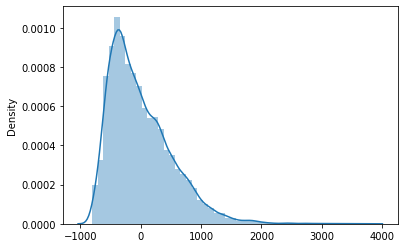

In [ ]:
from scipy.stats import moment
dist = y.values.ravel() - y.mean().values.ravel() 
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


mean: 0.0 , std: 4181.27897581471 , skew: 1100883.0967652714


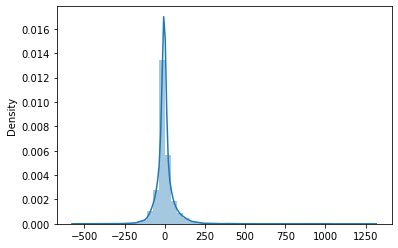

In [ ]:
from scipy.stats import moment
dist = y.diff('time', n=1).values.ravel()
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

In [ ]:
y = y.diff('time', 1)
y

<xarray.DataArray 'dis' (time: 13513)>
array([-6.15386963,  4.49841309, 17.52972412, ..., -4.65692139,
       -2.8092041 , 20.63201904])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-02 1981-01-03 ... 2017-12-31

In [ ]:
def reshape_scalar_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.
    Parameters
    ----------
    X_dis : xr.Dataset
        variables: time shifted predictors (name irrelevant)
        coords: time, latitude, longitude
    y : xr.DataArray
        coords: time
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    if isinstance(y, xr.Dataset):
        if len(y.data_vars) > 1:
            warnings.warn('Supplied `y` with more than one variable.'
                          'Which is the predictand? Supply only one!')
        for v in y:
            y = y[v]  # use the first
            break

    yar = y
    if len(yar.dims) > 1:
        raise NotImplementedError('y.dims: '+str(yar.dims) +
                                  ' Supply only one predictand dimension, e.g. `time`!')

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in yar.coords:
            yar = yar.drop(coord)

    # merge times
    yar.coords['features'] = 'predictand'
    Xy = xr.concat([Xar, yar], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xy  # last column is predictand
    # yda = Xy[:,].drop('features')  # features was only needed in merge
    yda = Xy[:,]
    return Xda, yda

In [ ]:
Xda, yda = reshape_scalar_predictand(X, y)
Xda.features

ValueError: ignored

In [ ]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [ ]:
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [ ]:
X_train.shape, y_train.shape

((9131, 17), (9131, 17))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.layers.core import Dropout
from keras.constraints import MinMaxNorm, nonneg


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


class DenseNN(object):
    def __init__(self, **kwargs):
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        self.output_dim=1
        
        model = keras.models.Sequential()
        self.cfg = kwargs
        hidden_nodes = self.cfg.get('hidden_nodes')
        
        model.add(keras.layers.Dense(hidden_nodes[0], 
                                     activation='tanh'))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(self.cfg.get('dropout', None)))
        
        for n in hidden_nodes[1:]:
            model.add(keras.layers.Dense(n, activation='tanh')) 
            model.add(keras.layers.BatchNormalization())
            model.add(Dropout(self.cfg.get('dropout', None)))
        model.add(keras.layers.Dense(self.output_dim, 
                                     activation='linear'))
        opt = keras.optimizers.Adam() 

        model.compile(loss=self.cfg.get('loss'), optimizer=opt)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        """
        ypred = self.predict(X)
        err_pred = ypred - y
        
        # NaNs do not contribute to error
        err_pred = err_pred.where(~np.isnan(err_pred), 0.)  
        return float(np.sqrt(xr.dot(err_pred, err_pred)))
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        Xda : xr.DataArray
            with coordinates (time,)
        """
        X = self.xscaler.transform(Xda.values)
        y = self.model.predict(X).squeeze()
        y = self.yscaler.inverse_transform(y)
        
        y = add_time(y, Xda.time, name=name)
        return y

    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """
        Input: xr.DataArray
        Output: None
        """
        
        print(X_train.shape)
        X_train = self.xscaler.fit_transform(X_train.values)
        y_train = self.yscaler.fit_transform(
                        y_train.values.reshape(-1, self.output_dim))
        
        X_valid = self.xscaler.transform(X_valid.values)
        y_valid = self.yscaler.transform(
                        y_valid.values.reshape(-1, self.output_dim))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.cfg.get('epochs', 1000),
                              batch_size=self.cfg.get('batch_size'),
                              callbacks=self.callbacks,
                              verbose=0, **kwargs)

In [ ]:
config = dict(hidden_nodes=(64,),  
                dropout=0.25,
                epochs=300,
                batch_size=90,
                loss='mse')

m = DenseNN(**config)

In [ ]:
hist = m.fit(X_train, y_train, X_valid, y_valid)

In [ ]:
m.model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(m.model, to_file='model.png', show_shapes=True)

In [ ]:
h = hist.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

In [ ]:
import os, yaml
dir_model = '../../models/tdnn-diff-batch90/'
os.makedirs(dir_model, exist_ok=True)

In [ ]:
yaml_string = m.model.to_json()
with open(dir_model+'keras-config.yml', 'w') as f:
    yaml.dump(yaml_string, f)
    
with open(dir_model+'model-config.yml', 'w') as f:
    yaml.dump(config, f, indent=4)
    
from contextlib import redirect_stdout
with open(dir_model+'summary.txt', "w") as f:
    with redirect_stdout(f):
        m.model.summary()

In [ ]:
# X_train.values.reshape(-1,1)
y_pred_train = m.predict(X_train)
y_pred_train = generate_prediction_array(y_pred_train, y_orig, forecast_range=14)

y_pred_valid = m.predict(X_valid)
y_pred_valid = generate_prediction_array(y_pred_valid, y_orig, forecast_range=14)

y_pred_test = m.predict(X_test)
y_pred_test = generate_prediction_array(y_pred_test, y_orig, forecast_range=14)

In [ ]:
title='Setting: Time-Delay Neural Net: 64 hidden nodes, dropout 0.25'
plot_multif_prediction(y_pred_test, y_orig, forecast_range=14, title=title);